## ch08
- https://github.com/thampiman/interpretable-ai-book/blob/master/Chapter_08/chapter_08_eda.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.10.05</div>
<div style="text-align: right"> Last update: 2023.10.05</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


이제 머신러닝 모델로 구동되는 시스템을 구축할 때 중요한 문제인 편향성 문제를 해결해 보겠습니다.  
이 문제는 여러 가지 이유로 중요합니다.  
우리는 개인이나 시스템 사용자를 차별하지 않는 시스템을 구축해야 합니다.  
기업이 기회를 제공하거나 서비스 또는 정보의 품질과 같은 의사결정에 AI를 사용하는 경우, 편향된 의사결정은 기업의 평판을 손상시키거나 고객의 신뢰에 부정적인 영향을 미침으로써 기업에 막대한 비용을 초래할 수 있습니다.  
미국 및 유럽과 같은 특정 지역에서는 성별, 인종, 민족, 성적 지향 등과 같은 보호 대상 속성에 근거하여 개인을 차별하는 것을 금지하는 법률이 있습니다.  
금융 서비스, 교육, 주택, 고용, 신용, 의료 등 일부 규제 대상 산업에서는 의사 결정 시 보호 속성의 사용을 금지하거나 제한하고 있으며, AI 시스템은 특정 공정성을 보장해야 합니다.

편향성과 공정성 문제를 살펴보기 전에, 그림 8.1과 같이 데이터 유출, 편향성, 규정 미준수, 개념 표류와 같은 일반적인 문제를 해결하는 강력한 AI 시스템을 구축하는 데 사용한 프로세스를 요약해 보겠습니다.  
학습, 테스트, 이해 단계는 오프라인에서 이루어지며, 과거 레이블이 지정된 데이터를 기반으로 모델을 학습하고, 평가하고, 다양한 해석 가능성 기법을 사용하여 이해하는 과정입니다.  
모델이 배포되면 온라인으로 전환되어 라이브 데이터에 대한 예측을 시작합니다.  
이 모델은 또한 프로덕션 환경의 데이터 배포가 개발 및 테스트 환경의 데이터 배포와 다를 때 발생하는 개념 이탈이 없는지 모니터링되며, 지속적인 학습, 평가 및 배포를 위해 새로운 데이터가 과거 학습 데이터 세트에 다시 추가되는 피드백 루프도 있습니다.

이 시스템에서 편향의 원인은 무엇일까요?  
그림 8.2에서 볼 수 있듯이 라벨링 프로세스에서 편향이 있거나 샘플링 또는 데이터 수집 프로세스에서 편향이 있을 수 있는 과거 학습 데이터 세트가 한 가지 원인입니다.  
또 다른 원인은 알고리즘이 특정 개인 또는 개인 그룹을 다른 개인보다 선호할 수 있는 모델 자체이며, 모델이 자체적으로 편향된 데이터 세트를 학습하는 경우 편향이 더욱 증폭됩니다.  
또 다른 편향의 원인은 프로덕션 환경에서 개발 및 테스트 환경으로 피드백 루프가 반복되는 것입니다.  
초기 데이터 세트 또는 모델이 편향된 경우 프로덕션에 배포된 모델은 계속해서 편향된 예측을 하게 되며, 이러한 예측을 기반으로 한 데이터가 학습 데이터로 피드백되면 이러한 편향은 더욱 강화되고 증폭됩니다.

![Alt text](image.png)

해석 가능성은 편향성 및 공정성 문제에서 어디에 적합할까요?  
그림8.2에서 볼 수 있듯이, 훈련과 테스트 중에 해석 가능성 기법을 사용하여 과거 데이터 세트 또는 모델의 문제를 노출할 수 있습니다.  
우리는 이미 3장에서 부분 의존도 플롯(PDP)을 사용한 고등학생 성적 예측 문제에서 인종 편향이 노출된 것을 보았습니다.  
모델을 배포한 후에는 해석 가능성 기법을 사용하여 모델 예측이 계속 공정하게 유지되도록 할 수 있습니다.  
이 장에서는 성인의 소득을 예측하는 또 다른 구체적인 예를 사용하여 편향성과 공정성에 대한 주제를 더 자세히 살펴볼 것입니다.  
그런 다음 공정성에 대한 다양한 개념에 대한 공식적인 정의를 제시하고 이를 사용하여 모델이 편향되었는지 여부를 판단합니다.  
그런 다음 해석 가능성 기법을 사용하여 공정성 문제를 측정하고 노출할 것입니다.  
또한 편향성을 완화하기 위한 기법도 논의할 것입니다.  
마지막으로, AI 시스템의 이해관계자 및 사용자와의 투명성과 책임성을 개선하는 데 도움이 되는 데이터시트를 사용하여 데이터세트를 문서화하는 표준화 접근 방식을 살펴봅니다.

### Adult income prediction

![Alt text](image-1.png)

그림 8.3에서 볼 수 있듯이 교육 수준, 직업, 나이, 성별, 인종, 자본 이득 등 소득 예측을 위한 다양한 입력이 주어집니다.  
우리는 이러한 입력을 받아 "성인이 연간 5만 달러 이상을 버는가?"라는 질문에 대한 예 또는 아니오 답변을 출력하는 직사각형 상자로 표시된 소득 예측자를 구축하는 임무를 수행해야 합니다. 따라서 이 문제는 예 또는 아니오라는 이진 답변에 관심이 있기 때문에 이진 분류 문제로 공식화할 수 있습니다.  
'예'라는 대답을 양수 레이블로, '아니오'라는 대답을 음수 레이블로 처리하며, 30,940명의 성인으로 구성된 인구조사국의 과거 데이터 세트가 주어집니다.  
입력 특징은 표 8.1에 요약되어 있습니다.  
표에서 연속형 변수와 범주형 변수가 혼합된 것을 볼 수 있습니다.  
이 책에서 다룬 대부분의 데이터 세트는 특징값이 실수인 연속형 특징들로 구성되었습니다.  
범주형 특징을 다루는 방법은 3장에서 살펴보았습니다.  
다시 말해, 범주형 특징은 값이 불연속적이고 유한한 특징입니다.  
이를 숫자 값으로 인코딩해야 하는데, 3장에서 라벨 인코더를 사용하여 인코딩하는 방법도 살펴봤습니다.

![Alt text](image-2.png)

또한 표 8.1에는 특정 기능이 보호 대상 속성인지 여부도 표시되어 있습니다.  
보호 속성은 많은 국가에서 공통적으로 적용되는 법률에 따라 개인을 차별하는 데 사용할 수 없는 속성입니다.  
예를 들어 미국에서는 1964년 민권법에 따라 성별, 인종, 나이, 피부색, 신념, 출신 국가, 성적 지향, 종교 등의 속성을 이유로 한 차별로부터 개인을 보호하고 있습니다. 영국에서는 2010년 평등법에 따라 동일한 속성을 가진 개인을 차별로부터 보호하고 있으며, 이 데이터 세트에서는 연령, 성별, 인종이라는 세 가지 보호 속성을 다루고 있습니다. 나이는 연속형 특성이고 성별과 인종은 범주형 특성입니다.  
이 장에서는 주로 성별과 인종에 초점을 맞추겠지만, 공정성 개념과 기법을 나이와 같은 연속적인 보호 속성으로 확장하는 방법을 배우게 될 것입니다.  
이 데이터 세트에서는 성별과 인종으로 남성과 여성이라는 두 가지 성별과 백인과 흑인이라는 두 가지 인종을 다루고 있습니다.  
안타깝게도 이 데이터 세트에는 더 많은 성별 또는 인종 그룹이 제대로 표현되어 있지 않기 때문에 더 많은 성별 또는 인종 그룹을 포함할 수 없습니다.

마지막으로, 이 데이터 집합의 대상 변수는 이진이며, 1은 성인의 연봉이 연간 5만 달러 이상임을 나타내고 0은 연봉이 연간 5만 달러 이하임을 나타냅니다. 이제 이 데이터 집합을 살펴보고 특히 전체 급여 분포와 두 가지 보호 대상 속성인 성별과 인종에 초점을 맞춰 살펴보겠습니다.

## EDA

In [3]:
df = pd.read_csv("adult.data",                  
                 names=['age', 'workclass', 'fnlwgt',
                        'education', 'education-num', 'marital-status',
                        'occupation', 'relationship', 'race',
                        'gender', 'capital-gain', 'capital-loss',
                        'hours-per-week', 'native-country', 'salary'])


In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
df_obj = df.select_dtypes(['object'])

In [7]:
df_obj.columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'salary'],
      dtype='object')

In [8]:
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [9]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
df['race'].value_counts()

race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64

In [11]:
df['gender'].value_counts()

gender
Male      21790
Female    10771
Name: count, dtype: int64

In [12]:
df_wb_mf = df[(df['race'].isin(['White', 'Black'])) & 
              (df['gender'].isin(['Male', 'Female']))].reset_index(drop=True)

In [13]:
df_wb_mf.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [14]:
len(df_wb_mf)

30940

distribution

In [15]:
def plot_vc_bar_charts(df, col, ax, color='b'):
    df_vc = df[col].value_counts() / len(df) * 100
    df_vc = df_vc.reset_index()
    df_vc = df_vc.rename(columns={'index': col, col: 'pc'})
    
    bar_width = 0.35
    opacity = 0.9
    labels = df_vc[col].values
    capitalized_labels = []
    for label in labels:
        words = label.split(' ')
        capitalized_label = ' '.join([w.capitalize() for w in words])
        capitalized_labels.append(capitalized_label)
    sizes = df_vc['pc'].values
    index = np.arange(len(sizes))
    
    ax.bar(index, sizes, bar_width,
           alpha=opacity,
           label=labels,
           color=color)
    ax.set_xticks(index)
    ax.set_xticklabels(capitalized_labels)
    ax.grid(True);

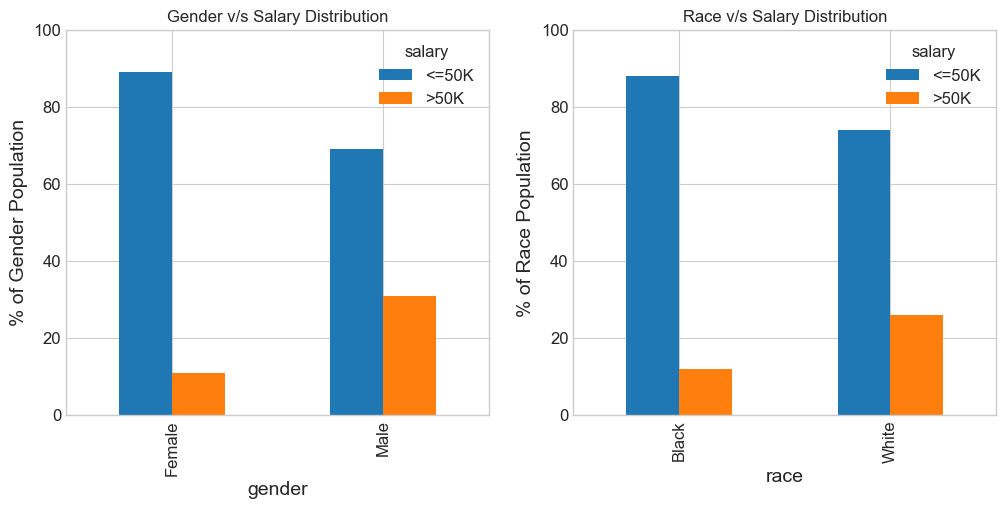

In [16]:
# Compute Gender v/s Salary Distribution
gender = round(pd.crosstab(df_wb_mf.gender, 
                           df_wb_mf.salary).\
               div(pd.crosstab(df_wb_mf.gender, 
                               df_wb_mf.salary).apply(sum, 1), 0), 2)
gender.sort_values(by = '>50K', inplace = True)
gender = gender * 100

# Compute Race v/s Salary Distribution
race = round(pd.crosstab(df_wb_mf.race, 
                         df_wb_mf.salary).\
             div(pd.crosstab(df_wb_mf.race, 
                             df_wb_mf.salary).apply(sum, 1), 0), 2)
race.sort_values(by='>50K', inplace=True)
race = race * 100

f, ax = plt.subplots(1, 2, figsize=(12, 5))
gender.plot(kind='bar', 
            title='Gender v/s Salary Distribution', 
            ax=ax[0])
ax[0].set_ylim([0, 100])
ax[0].set_ylabel('% of Gender Population');
race.plot(kind='bar', 
          title='Race v/s Salary Distribution', 
          ax=ax[1])
ax[1].set_ylim([0, 100])
ax[1].set_ylabel('% of Race Population');

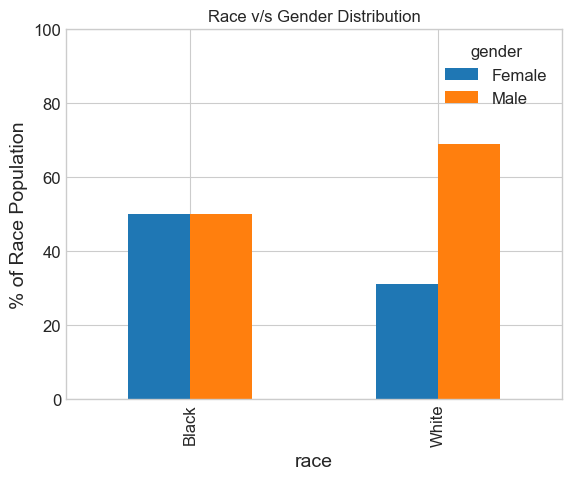

In [17]:
rg = round(pd.crosstab(df_wb_mf.race, 
                       df_wb_mf.gender).\
           div(pd.crosstab(df_wb_mf.race, 
                           df_wb_mf.gender).apply(sum, 1), 0), 2)
rg = rg * 100
f, ax = plt.subplots()
rg.plot(kind='bar', 
        title='Race v/s Gender Distribution', 
        ax=ax)
ax.set_ylim([0, 100])
ax.set_ylabel('% of Race Population');

![Alt text](image-3.png)

- 그림 8.4는 인구조사국에서 제공한 데이터세트에 포함된 30,940명의 성인에 대한 급여, 성별, 인종의 전체 분포를 보여줍니다. 
- 데이터 세트가 실제로 편향적으로 왜곡되어 있음을 알 수 있습니다.  
- 인구의 약 75%가 5만 달러 이하의 연봉을 받고 있으며, 나머지는 5만 달러 이상의 연봉을 받고 있습니다. 성별로는 인구의 약 65%가 남성인 이 데이터 세트에서 남성 성인이 여성 성인보다 더 많이 나타나고 있습니다.  
- 인종도 마찬가지로, 데이터 세트에 포함된 성인의 약 90%가 백인이라는 점에서 백인 성인에 대한 편향성을 확인할 수 있습니다. 

이제 다양한 보호 대상 성별 및 인종 그룹의 급여 분포를 살펴보고 편견이 있는지 확인해 보겠습니다.  
이는 그림 8.5에 나와 있습니다.  
성별을 살펴보면 여성보다 남성 성인의 연봉이 5만 달러 이상인 비율이 더 높다는 것을 알 수 있습니다.  
인종에 대해서도 동일한 관찰을 할 수 있는데, 흑인 성인보다 백인 성인의 소득이 5만 달러 이상 높은 비율이 더 높습니다.

![Alt text](image-4.png)

마지막으로, 그림 8.6에 표시된 이 데이터 집합의 두 인종에 대한 성별 표현을 살펴보겠습니다.  
흑인 성인의 경우 남성과 여성의 비율이 약 50%로 상당히 균등하다는 것을 알 수 있습니다.  
반면에 백인 성인의 경우 백인 여성보다 백인 남성 성인이 더 많이 나타납니다.  
이 분석은 급여 편향의 주요 원인을 파악하는 데 유용합니다.  
백인 성인의 70%가 남성이기 때문에 백인 성인의 급여 편향은 데이터 세트에서 남성 사용자가 여성 사용자보다 더 많은 수입을 올릴 수 있는 성별 보호 그룹으로 더 잘 설명될 수 있으며, 반면에 흑인 성인의 경우 남성과 여성의 비율이 거의 균등하기 때문에 흑인 성인의 주요 편향의 원인은 인종 자체일 수 있습니다.

![Alt text](image-5.png)

모델을 구축하기 전에 데이터 세트에서 이러한 편향의 근본 원인을 이해하는 것이 중요합니다.  
데이터 세트가 어떻게 수집되었는지 확실하지 않으므로, 따라서 근본 원인을 확신할 수 없습니다.  
하지만 다음과 같은 가설을 세울 수 있습니다.  

편향의 원인은 다음과 같을 수 있습니다:
- 샘플링 편향: 데이터 세트가 실제 모집단을 제대로 대표하지 못하는 경우.
- 라벨링 편향: 급여 정보가 다양한 집단에 대해 기록되는 방식에 편향이 존재할 수 있습니다.
- 시스템적 편향이 있는 경우 해당 편향이 데이터 집합에 반영됩니다.

장에서 이미 논의했듯이 첫 번째 문제는 모집단을 대표할 수 있는 데이터를 더 많이 수집함으로써 해결할 수 있습니다.  
이 장에서는 투명성과 책임성을 높이기 위해 데이터시트를 사용하여 데이터 수집 프로세스를 적절히 문서화하는 방법에 대해서도 알아봅니다.  
이러한 데이터시트는 데이터 집합에서 편향의 근본 원인을 파악하는 데에도 사용할 수 있습니다.  
라벨링 편향은 데이터 수집 프로세스를 개선함으로써 해결할 수 있습니다.  
이 장에서는 레이블 편향을 수정하는 또 다른 기법에 대해서도 알아보겠습니다.   
마지막 문제는 해결하기가 훨씬 더 어렵고 더 나은 정책과 법률이 필요하며 이 책의 범위를 벗어납니다.